# Test Problem : Solving Damped Harmonic Oscillator DE over varying Damping Ratio

    Using PyTorch, solve the damped harmonic oscillator [5] using a PINN. Choose fixed initial conditions:
    x(0) = x₀,
     dx/dz(0) = v₀, with x₀ = 0.7 and v₀ = 1.2.
    
    Condition the PINN on damping ratios in the range ξ = 0.1 to 0.4.
    Solve on the domain z ∈ [0, 20]:
    d²x/dz² + 2ξ·dx/dz + x = 0


## Overview:

#### The following notebook deals with solving 1-D Damped Harmonic Oscillator Differential Equation with a varying damping ratio, using a simple Physics Informed Neural Network. The PINN model is sucessfully able to predict the curve of solution with different values of damping ratios (chosen randomly here) through just:

#### - 20 Ground Truth Data Training Points (All the start of the trajectory)
#### - 60 Collocation Points (Where the Physics is enforced)

### Importing Libraries

In [1]:
# Importing the necessary libraries:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.optim as optim

#### Functions to avoid errors in Pytorch workflow (may be useful in large scripts):

In [2]:
# Check for device (CPU/CUDA):
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Ensures the tensor is on cpu before converting to a Numpy array for plotting purpose     
def ensure_cpu(tensor_input):
 
    if isinstance(tensor_input, torch.Tensor):
        if tensor_input.is_cuda:
            return tensor_input.detach().cpu()
        else:
            return tensor_input
    elif isinstance(tensor_input, (list, tuple)):
        return type(tensor_input)(ensure_cpu(item) for item in tensor_input)
    elif isinstance(tensor_input, dict):
        return {key: ensure_cpu(value) for key, value in tensor_input.items()}
    else:
        return tensor_input




# to convert numpy to tensor wherever needed:
def to_tensor(data):
    if isinstance(data, torch.Tensor):
        return data.float()
    elif isinstance(data, np.ndarray):
        return torch.from_numpy(data).float()
    else:
        return torch.tensor(data, dtype=torch.float32)  # to avoid float32 - float 64 mismatch


Using device: cuda


#### Defining Analytical solution for low range damping ratio for training and testing purpose:

In [3]:

# For generating Analytical solution for Damped Oscillator for given intial conditions and damping
x0 = 0.7
v0 = 1.2
z = np.linspace(0, 20, 2000)  # Time domain
d = np.random.uniform(0.1, 0.4) # randomly selecting a damping constant between 0.1 and 0.4
print(f"Randomly Selected damping constant: {d}")
def damped_oscillator(z, d):
    omega_d = np.sqrt(1 - d**2)  # Damped frequency
    C1 = x0
    C2 = (v0 + d * x0) / omega_d
    y = np.exp(-d * z) * (C1 * np.cos(omega_d * z) + C2 * np.sin(omega_d * z))
    return y

Randomly Selected damping constant: 0.3921940986481829


#### Model Architecture:

In [4]:
# defining the model architecture:

class Model(nn.Module):
    "Defines a connected network"
    
    def __init__(self, n_input, n_ouput, n_hidden, n_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_input, n_hidden),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(n_hidden, n_hidden),
                            activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_hidden, n_ouput)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

#### Taking 20 points at the start of trjectory as data loss trainig points:

torch.Size([1000, 1]) (1000, 1)
torch.Size([20, 1]) (20, 1)
<class 'numpy.ndarray'>


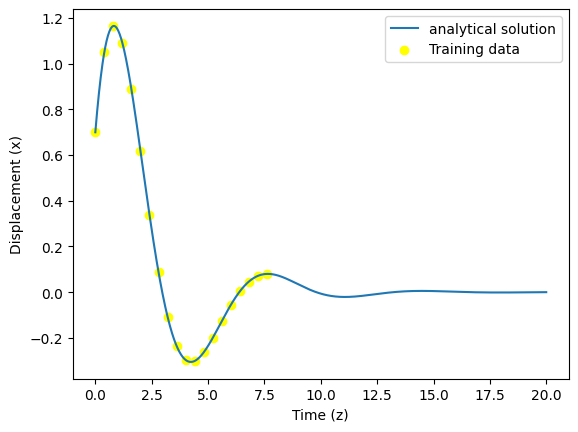

In [5]:
# training data:
z = torch.linspace(0,20,1000).view(-1,1)
x = damped_oscillator(z.numpy(), d) # analytical solution

print(z.shape, x.shape)

# slice out a small number of points from the LHS of the domain
z_data = z[0:400:20]
x_data = x[0:400:20]

print(z_data.shape, x_data.shape)
print(type(x_data))
plt.figure()
plt.plot(z, x, label="analytical solution")
plt.scatter(z_data, x_data, color="yellow", label="Training data")
plt.xlabel("Time (z)")
plt.ylabel("Displacement (x)")
plt.legend()
plt.show()



In [6]:
# for saving GIFs of the solution:
def save_gif_PIL(outfile, files, fps=10, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
    
def display_gif(gif_path):
    """Display the GIF with autoplay"""
    return HTML(f'<img src="{gif_path}" alt="PINN Training Animation" style="width:100%">')

In [7]:
print(d)

0.3921940986481829


In [8]:
# plotting function:

def plot_result(z, x, z_data, x_data, xpred1, colloc, d):
    # converting GPU tensors to CPU for plotting:
    z = ensure_cpu(z)
    x = ensure_cpu(x)
    
    
    z_data = ensure_cpu(z_data) # training time points2
    x_data = ensure_cpu(x_data) # training solutions
    xpred1 = ensure_cpu(xpred1) # predictions by normal NN
    if colloc is not None: colloc = ensure_cpu(colloc)
    
    # plotting:
    plt.figure(figsize=(8,4))
    plt.plot(z, x, color="grey", linewidth=2, alpha=0.8, label="Analytical solution")
    plt.plot(z, xpred1, color="blue", linewidth=4, alpha=0.8, label="PINN prediction")
    plt.scatter(z_data, x_data, s=60, color="orange", alpha=0.4, label='Training data')
    if colloc is not None:
        plt.scatter(colloc, -0*torch.ones_like(colloc), s=60, color="green", alpha=0.4, 
                    label='Physics Collocation Points') # collocation points
    legend = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(legend.get_texts(), color="k")
    plt.xlim(-0.05, 20.05)
    plt.ylim(-2, 2)
    plt.text(1.85,1.5,"Training step: %i ; damping constant = %.2f "%(i+1, d),fontsize="xx-large",color="k")
    plt.xlabel("Time (z)", fontsize="xx-large")
    plt.ylabel("Displacement (x)", fontsize="xx-large")

# PINN:

#### Here we will define the PINN training workflow and add the PDE residual to the loss function of the Neural Network.

c:\Users\mehul\anaconda3\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration 1 - Loss: 0.429843, Data Loss: 0.401441, Physics Loss: 0.028402
Iteration 2 - Loss: 0.370786, Data Loss: 0.362239, Physics Loss: 0.008547
Iteration 3 - Loss: 0.334106, Data Loss: 0.333430, Physics Loss: 0.000676
Iteration 4 - Loss: 0.315481, Data Loss: 0.313206, Physics Loss: 0.002275
Iteration 5 - Loss: 0.308204, Data Loss: 0.299131, Physics Loss: 0.009073
Iteration 6 - Loss: 0.305620, Data Loss: 0.288789, Physics Loss: 0.016831
Iteration 7 - Loss: 0.302796, Data Loss: 0.280213, Physics Loss: 0.022583
Iteration 8 - Loss: 0.297213, Data Loss: 0.272204, Physics Loss: 0.025009
Iteration 9 - Loss: 0.288474, Data Loss: 0.264316, Physics Loss: 0.024158
Iteration 10 - Loss: 0.277455, Data Loss: 0.256601, Physics Loss: 0.020854
Iteration 11 - Loss: 0.265519, Data Loss: 0.249319, Physics Loss: 0.016200
Iteration 12 - Loss: 0.253984, Data Loss: 0.242724, Physics Loss: 0.011260
Iteration 13 - Loss: 0.243801, Data Loss: 0.236921, Physics Loss: 0.006881
Iteration 14 - Loss: 0.235389, Dat

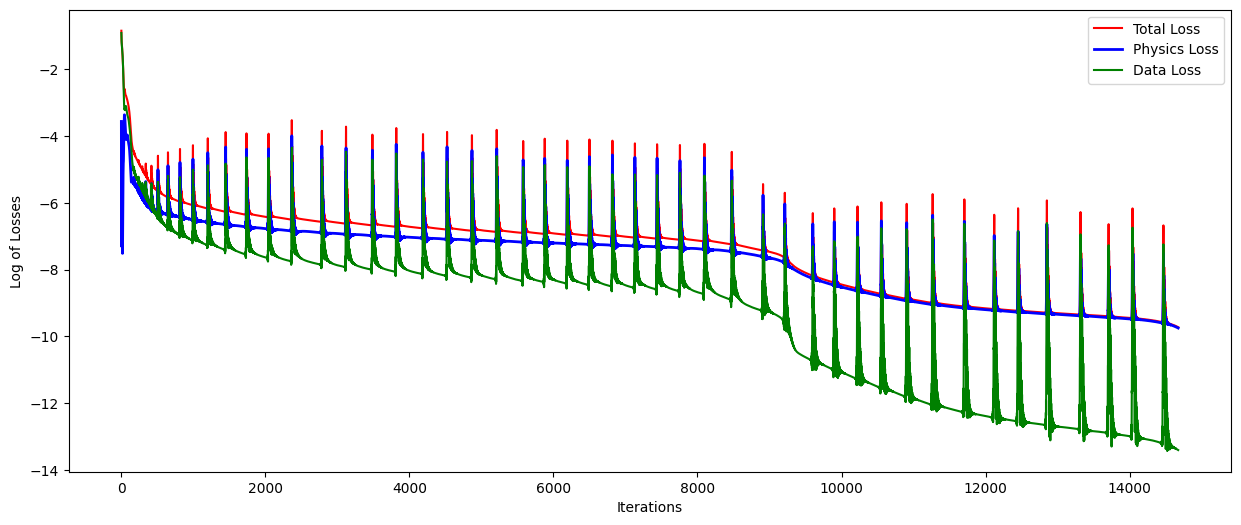

In [ ]:
colloc = torch.linspace(0,20,60).view(-1,1).requires_grad_(True)  # 60 Collocation Points
colloc = to_tensor(colloc).to(device)
z_data = to_tensor(z_data).to(device)
x_data = to_tensor(x_data).to(device)
z = to_tensor(z).to(device)

# For plotting:
Losses = []
Phy_loss = []
Data_loss = []

torch.manual_seed(123)
model = Model(1,1,32,4) 
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = [] # for saving solution images

# Training loop until total loss < 0.000060
max_epochs = 100000  # Safety limit
i = 0  # Iteration counter

while i < max_epochs:
    optimizer.zero_grad()
    
    # Computing Data loss: 
    xpred2 = model(z_data)  # Predictions for data samples
    loss1 = torch.nn.functional.mse_loss(xpred2, x_data)  # MSE loss for data
    
    # Computing Physics loss:
    col_pred = model(colloc)  # Predictions for collocation points
    dx  = torch.autograd.grad(col_pred, colloc, torch.ones_like(col_pred), create_graph=True)[0]  # Computes dy/dx
    dx2 = torch.autograd.grad(dx,  colloc, torch.ones_like(dx),  create_graph=True)[0]  # Computes d^2y/dx^2
    p_residual = dx2 + 2*d*dx + col_pred  # Computes residual of harmonic oscillator equation
    loss2 = torch.mean(p_residual**2)
    
    # Backpropagate joint loss
    loss = loss1 + loss2  # Total loss
    Losses.append(loss.item())
    Data_loss.append(loss1.item())
    Phy_loss.append(loss2.item())
    
    loss.backward()
    optimizer.step()
    
    print(f"Iteration {i+1} - Loss: {loss:.6f}, Data Loss: {loss1:.6f}, Physics Loss: {loss2:.6f}")
    
    # Stopping training if loss is below threshold:
    threshold = 6e-5
    if loss.item() < threshold:
        print(f"Stopping early at iteration {i+1}: Loss reached {loss:.6f}")
        break

    # Plot results every 600 iterations
    if (i+1) % 600 == 0:
        xpred2 = model(z).detach()
        col_pred = colloc.detach()

        plot_result(z, x, z_data, x_data, xpred2, col_pred, d)

        file = f"C:\\Users\\mehul\\MyLab\\PINNDE\\plot2\\pinn_{i+1:08d}.png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        plt.close()
        # if (i+1) % 3000 == 0:
        #     plt.show()
        # else:
        #     plt.close("all")

    i += 1  # Increment iteration counter

# Save animation
save_gif_PIL("pinn.gif", files, fps=30, loop=0)
display(display_gif("pinn.gif"))

# Plot Losses
iterations = np.arange(1, len(Losses) + 1)
plt.figure(figsize=(15,6))
plt.plot(iterations, np.log(Losses), color="red", label="Total Loss")
plt.plot(iterations, np.log(Phy_loss), color="blue", linewidth=2, label="Physics Loss")
plt.plot(iterations, np.log(Data_loss), color="green", label="Data Loss")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log of Losses")
plt.show()
